<h2 align=center> Facial Expression Recognition</h2>

### Task 1: Import Libraries

In [1]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
import cv2
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau


from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF
import tensorflow as tf
print("Tensorflow version:", tf.__version__)


Tensorflow version: 2.8.0


### Task 2: Plot Sample Images

happy
.DS_Store
sad
fear
surprise
neutral
angry
disgust


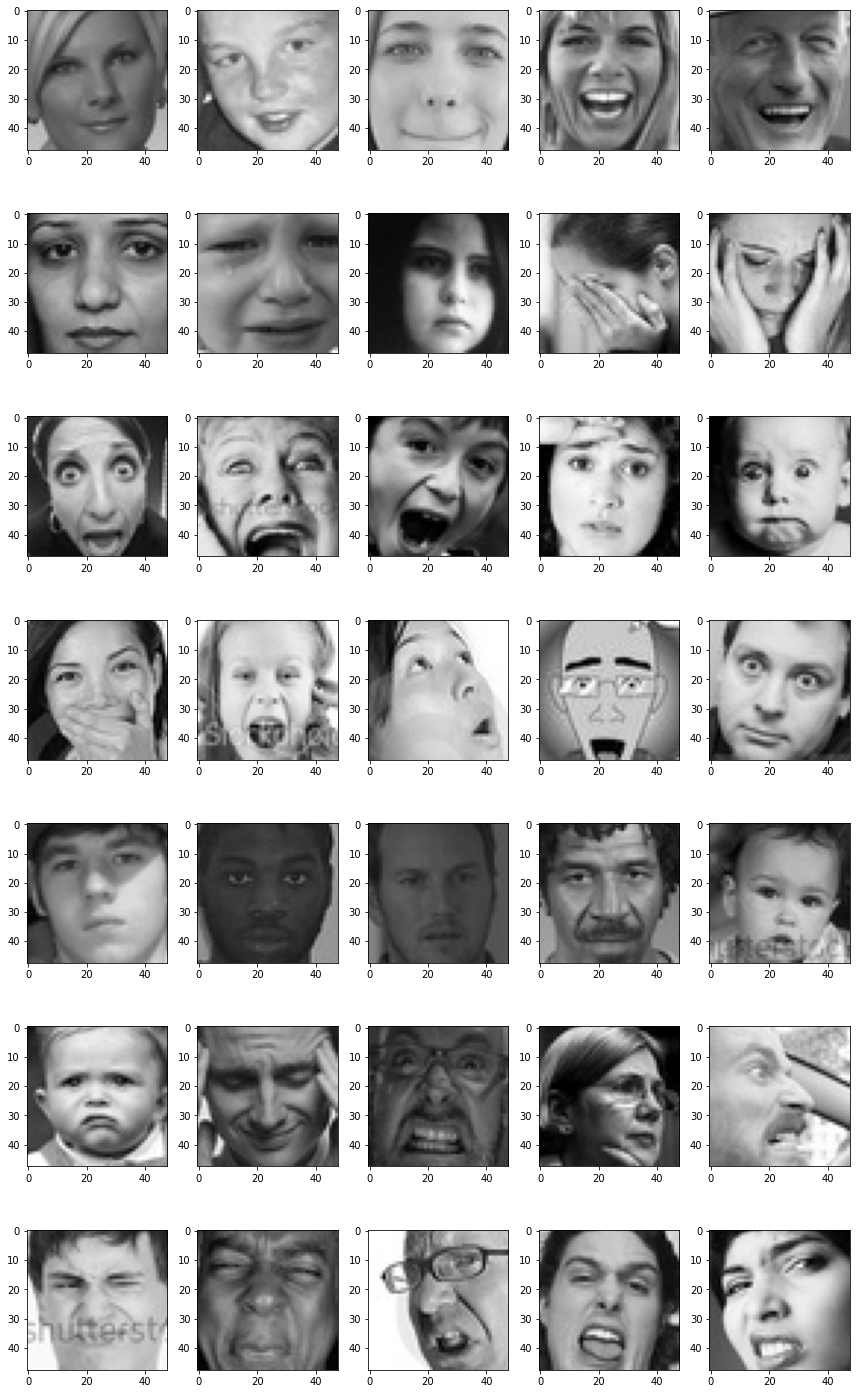

In [2]:
utils.datasets.fer.plot_example_images(plt).show()

In [3]:
for expression in os.listdir("train_1/"):
    if not expression.startswith('.'):
        print(str(len(os.listdir("train_1/" + expression))) + " " + expression + " images")

101 happy images
101 sad images
101 fear images
101 surprise images
101 neutral images
101 angry images
101 disgust images


### Task 3: Generate Training and Validation Batches

In [4]:
def create_new_data(old_folder, new_folder):
    for expression in os.listdir(old_folder):
        if not expression.startswith('.'):
            e = str(expression)
            for it, img_i in enumerate(os.listdir(old_folder + e + '/')):
                img = cv2.imread(old_folder + e + '/' + str(img_i))
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img2 = np.zeros_like(img)
                img2[:, :, 0] = gray
                img2[:, :, 1] = gray
                img2[:, :, 2] = gray
                path_img = new_folder + e + '/'
                cv2.imwrite(os.path.join(path_img, str(img_i)), img)
                if it == 100:
                    break
                else:
                    continue


In [5]:
create_new_data('train/','train_1/')
create_new_data('test/','test_1/')

In [6]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True)

train_generator = datagen_train.flow_from_directory("train_1/",
                                                    target_size=(img_size,img_size),
                                                    # color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_validation.flow_from_directory("test_1/",
                                                    target_size=(img_size,img_size),
                                                    # color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 707 images belonging to 7 classes.
Found 707 images belonging to 7 classes.


### Task 4: Create CNN Model

In [ ]:
# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# MODEL WITH VGG 16


In [7]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    pooling='avg',
    input_shape=(48, 48, 3)
)


2022-02-11 15:46:36.973175: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [9]:
# freeze it!
base_model.trainable = False

In [10]:
model = Sequential()
model.add(base_model)

# # Flattening
# model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Dropout(0.5))

# Fully connected layer 2nd layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Dropout(0.5))

# Fully connected layer 3rd layer
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                        

/Users/stefan/opt/anaconda3/envs/deep_photos/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Task 6: Train and Evaluate Model

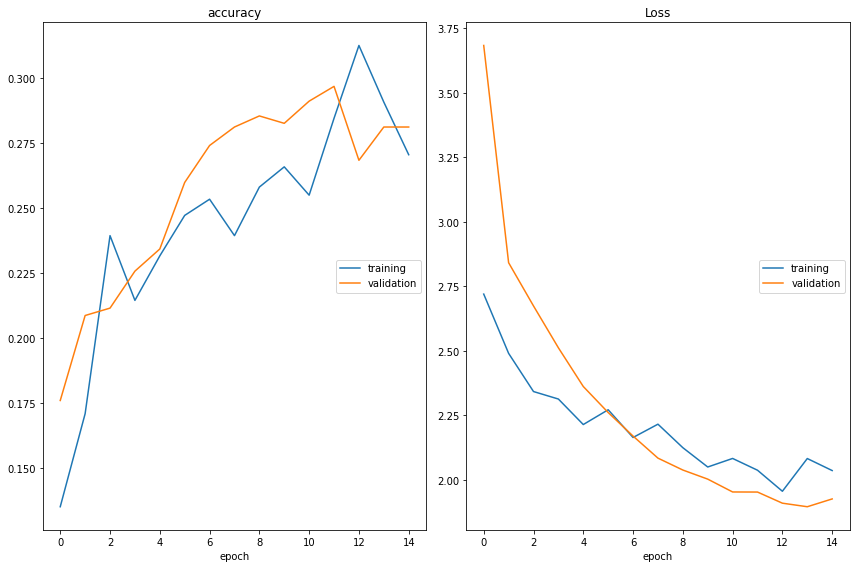

accuracy
	training         	 (min:    0.135, max:    0.313, cur:    0.271)
	validation       	 (min:    0.176, max:    0.297, cur:    0.281)
Loss
	training         	 (min:    1.956, max:    2.720, cur:    2.036)
	validation       	 (min:    1.896, max:    3.684, cur:    1.926)

Epoch 15: saving model to model_weights.h5
11/11 [==============================] - 24s 2s/step - loss: 2.0361 - accuracy: 0.2706 - val_loss: 1.9261 - val_accuracy: 0.2812 - lr: 5.0000e-04
CPU times: user 26min 5s, sys: 1min 41s, total: 27min 46s
Wall time: 5min 49s


In [11]:
%%time

epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr]

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

### Task 7: Represent Model as JSON String

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [12]:
ModelCheckpoint?

Init signature:
ModelCheckpoint(
    filepath,
    monitor='val_loss',
    verbose=0,
    save_best_only=False,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    options=None,
    initial_value_threshold=None,
    **kwargs,
)
Docstring:     
Callback to save the Keras model or model weights at some frequency.

`ModelCheckpoint` callback is used in conjunction with training using
`model.fit()` to save a model or weights (in a checkpoint file) at some
interval, so the model or weights can be loaded later to continue the training
from the state saved.

A few options this callback provides include:

- Whether to only keep the model that has achieved the "best performance" so
  far, or whether to save the model at the end of every epoch regardless of
  performance.
- Definition of 'best'; which quantity to monitor and whether it should be
  maximized or minimized.
- The frequency it should save at. Currently, the callback supports saving at
  the end of every epoch, o